In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import ensemble

In [2]:
df = pd.read_csv('Data/diabetic_data.csv')
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


### Background on the dataset

This dataset comes from a study published in BioMed Research International that investigated the effects of HbA1c measurement on hospital readmission rates in the US. Fortunately for me, the dataset has a thorough description of the variable types and % missing. The original study will be included in the GitHub repo for reference.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            10176

### Data cleaning

None of the data is null, but many values are missing in certain variables according to the description. We will need to handle these features before modelling the data. Additionally, we will engineer some new features.

In [4]:
# use copy of df to preserve original data, drop values with > 50% missing data

df2 = df.copy()

df2.drop(['weight', 'payer_code', 'medical_specialty'], axis=1, inplace=True)

# Feature engineering

### Convert ages from nominal to ordinal values

In [5]:
df2.age.replace({'[0-10)':0,
              '[10-20)':1,
              '[20-30)':2,
              '[30-40)':3,
              '[40-50)':4,
              '[50-60)':5,
              '[60-70)':6,
              '[70-80)':7,
              '[80-90)':8,
               '[90-100)':9}, inplace=True)

One of the major challenges will be finding ways to reduce the number of groups in the categorical variables. According to the description, some of the coded variables have over 900 distinct nominal values. If we wanted to model these features it would be simply too much data to process. We can aggregate the large varieties of groups into smaller broader categories.

### Convert diagnosis features to broader categories using ICD-9 codes 

Some values are coded using alpha chars, these will be difficult to sort through so let's convert everything to a numeric char and then set the dtype to float before converting to broader categories.

In [6]:
# Change V01-V91 format to 1000-1099 and E000-E999 to 2000-2999, convert dtype to float

diagnoses = ['diag_1', 'diag_2', 'diag_3']

for var in diagnoses:
    
    # Convert V01-V91 format to 1000-1099, must convert to str so that the second loop doesnt raise error
    for i in list((df2.loc[df2[var].str.contains('V'), var]).index):
        df2.loc[i, var] = str(int(df2.loc[i, var][1:]) + 1000)

    # Convert  E000-E999 to 2000-2999
    for j in list((df2.loc[df2[var].str.contains('E'), var]).index):
        df2.loc[j, var] = str(int(df2.loc[j, var][1:]) + 2000)


There remains a '?' character which represents null values, we will set these values to Nan.

In [7]:
# Convert dtypes to float, set nan to 0 to avoid errors when categorizing

for var in diagnoses:
    df2.loc[:, var] = pd.to_numeric(df2.loc[:,var], errors='coerce')
    
df2.loc[:,diagnoses].fillna(0, inplace=True)

In [8]:
replace_list = ['infections, parasites', 'neoplasms', 'endocrine, nutr, metab, immun', 'blood', 'mental', 
                'nervous', 'circulatory', 'respiratory', 'digestive', 'genitourinary', 'pregnancy/childbirth',
               'skin', 'musculoskeletal', 'congenital', 'perinatal', 'ill-defined conditions', 'injury/poisioning',
               'supplementary classification of factors influencing health status',
               'supplementary classification of causes of injury/poisoning']

cutoffs = [1, 140, 240, 280, 290, 320, 390, 460, 520, 580, 630, 680, 710, 740, 760, 780, 800, 1000, 2000, 4000]

# Use the replace_list and cutoffs to sort the diagnosis variables into new features

for var in diagnoses:
    newvar = var + '_sorted'
    df2[newvar] = df2[var]
    for i in range(len(replace_list)):
        df2.loc[(df2[var] >= cutoffs[i]) & (df2[var] < cutoffs[i+1]), newvar] = replace_list[i]

In [9]:
df2[['diag_1_sorted','diag_2_sorted','diag_3_sorted']].head()

,diag_1_sorted,diag_2_sorted,diag_3_sorted
0,"endocrine, nutr, metab, immun",NaN,NaN
1,"endocrine, nutr, metab, immun","endocrine, nutr, metab, immun","endocrine, nutr, metab, immun"
2,pregnancy/childbirth,"endocrine, nutr, metab, immun",supplementary classification of factors influe...
3,"infections, parasites","endocrine, nutr, metab, immun",circulatory
4,neoplasms,neoplasms,"endocrine, nutr, metab, immun"


### Create a feature that sums the total number of hospital visits in previous year

In [10]:
df2['num_hosp_visits'] = df2['number_outpatient'] + df2['number_inpatient'] + df2['number_emergency']

### Create binary feature that categorizes discharge as 'discharged to home' or not

In [11]:
df2['discharged_home'] = np.where(df2['discharge_disposition_id'] == 1, 1, 0)

### Create binary features that categorizes admission by emergency room, referral, or other

In [12]:
df2['emergency_room'] = np.where(df2['admission_source_id'] == 7, 1, 0)
df2['referral'] = np.where((df2['admission_source_id'] == 1) | (df2['admission_source_id'] == 2) |
                           (df2['admission_source_id'] == 3), 1, 0)

### Create two outcome variables, readmittance and readmittance within 30 days

In [13]:
df2['binary_readmitted'] = np.where(df2['readmitted'] == 'NO', 0, 1)
df2['binary_readmitted30'] = np.where(df2['readmitted'] == '<30', 1, 0)

# Generate Boosted Gradiant model to show predictive potential and identify most important features

In [46]:
y = df2['readmitted']

# Add numeric and ordinal features

X = df2.loc[:, ('age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures','num_medications',
                'number_outpatient', 'number_emergency','number_inpatient', 'number_diagnoses', 'num_hosp_visits',
               'discharged_home', 'emergency_room', 'referral')]
# Add categorical dummies

X = pd.concat([X, pd.get_dummies(df2.loc[:,('race', 'gender', 'max_glu_serum', 'A1Cresult', 'metformin', 
                                     'repaglinide', 'nateglinide','chlorpropamide', 'glimepiride', 
                                     'acetohexamide', 'glipizide','glyburide', 'tolbutamide', 
                                     'pioglitazone', 'rosiglitazone', 'acarbose','miglitol',
                                     'troglitazone', 'tolazamide', 'examide', 'citoglipton','insulin', 
                                     'glyburide-metformin', 'glipizide-metformin',
                                     'glimepiride-pioglitazone', 'metformin-rosiglitazone',
                                     'metformin-pioglitazone', 'change','diabetesMed',
                                    'diag_1_sorted', 'diag_2_sorted', 'diag_3_sorted')], drop_first=True)], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 1)

In [47]:
# Check the final number of features included in the model

print('There are {} features included in the model... yikes'.format(len(X.columns)))

There are 127 features included in the model... yikes


In [48]:
# Initialize and fit the model with default params
clf = ensemble.GradientBoostingClassifier()
clf.fit(X_train, y_train)

print((
    'Train set mean accuracy: {}\n'
    'Test set mean accuracy: {}'
).format(clf.score(X_train, y_train), clf.score(X_test, y_test)))

Train set mean accuracy: 0.585343683977792
Test set mean accuracy: 0.5854868821853199


Well the model did not perform great, but we can start to trim down our feature set, tune this model for better performance, and explore other model types. 

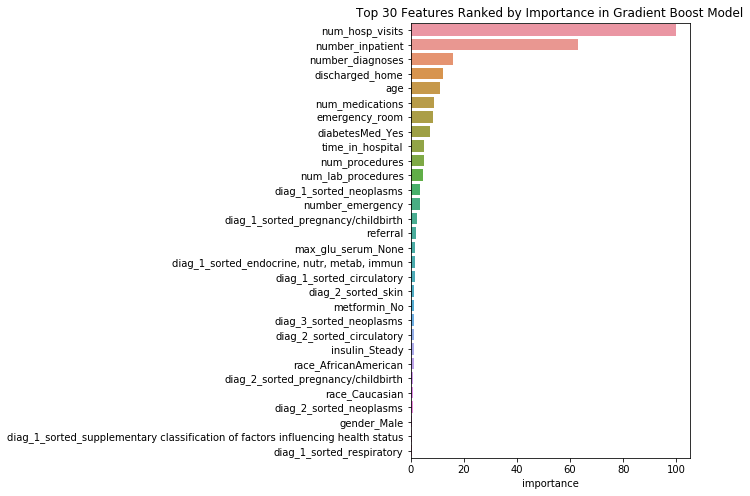

In [49]:
feature_importance = clf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())

feature_df= pd.DataFrame({'features': X.columns,
                          'importance':feature_importance})

feature_df.sort_values(by='importance', ascending=False, inplace=True)

feature_df.index = range(len(feature_df.features))

plt.figure(figsize=(5,8))

sns.barplot(y=feature_df.features[:30], x=feature_df.importance[:30])

plt.title('Top 30 Features Ranked by Importance in Gradient Boost Model')
plt.ylabel('')
plt.show()

It appears that there is a steep drop in importance as we move down the feature list. Let's see how far we can trim our feature set without sacrificing our accuracy.

# Model exploration

In [50]:
# Get stratified sample of dataset that preserves the class sizes of the original data, get dummies

sampled_df = df2.loc[df2['readmitted'] == 'NO'].sample(frac=0.1, random_state=1)
sampled_df = sampled_df.append(df2.loc[df2['readmitted'] == '<30'].sample(frac=0.1, random_state=1))
sampled_df = sampled_df.append(df2.loc[df2['readmitted'] == '>30'].sample(frac=0.1, random_state=1))


sampled_df = pd.concat([sampled_df, pd.get_dummies(sampled_df.loc[:,('race', 'gender', 'admission_type_id', 'discharge_disposition_id', 
                                     'admission_source_id', 'max_glu_serum', 'A1Cresult', 'metformin', 
                                     'repaglinide', 'nateglinide','chlorpropamide', 'glimepiride', 
                                     'acetohexamide', 'glipizide','glyburide', 'tolbutamide', 
                                     'pioglitazone', 'rosiglitazone', 'acarbose','miglitol',
                                     'troglitazone', 'tolazamide', 'examide', 'citoglipton','insulin', 
                                     'glyburide-metformin', 'glipizide-metformin',
                                     'glimepiride-pioglitazone', 'metformin-rosiglitazone',
                                     'metformin-pioglitazone', 'change','diabetesMed',
                                    'diag_1_sorted', 'diag_2_sorted', 'diag_3_sorted')], drop_first=True)], axis=1)

In [51]:
# Split dataset for modeling

y2 = sampled_df['readmitted']
X2 = sampled_df[feature_df.loc[:20, 'features']]

X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2,test_size = 0.2, random_state = 1)

In [20]:
from sklearn.model_selection import cross_val_score

In [21]:
# Initialize and fit the model with default params
clf = ensemble.GradientBoostingClassifier()
clf.fit(X2_train, y2_train)

# Calculate train set performance

train_scores = cross_val_score(clf, X2_train, y2_train, cv=10)
train_mean = np.mean(train_scores)
train_range = train_scores.max()-train_scores.min()

# Calculate test set performance

test_scores = cross_val_score(clf, X2_test, y2_test, cv=10)
test_mean = np.mean(test_scores)
test_range = test_scores.max()-test_scores.min()


print((
    'Train set statistics\n'
    'Train set mean accuracy across 10 cv folds: {}\n'
    'Train set cv score range across 10 cv folds: {}\n\n'
    'Test set statistics\n'
    'Test set mean accuracy across 10 cv folds: {}\n'
    'Test set cv score range across 10 cv folds: {}\n'
).format(train_mean,train_range,test_mean,test_range))

Train set statistics
Train set mean accuracy across 10 cv folds: 0.5728562696669912
Train set cv score range across 10 cv folds: 0.04931368332088237

Test set statistics
Test set mean accuracy across 10 cv folds: 0.5682877422634234
Test set cv score range across 10 cv folds: 0.05124118612962425



### Testing various classifiers

We preserved most of the accuracy of the dataset while trimming our feature set down from 159 to 20. Now let's use cross validation to test various classification models. We will use the exploratory model selection to choose a final model that we can tune.

In [23]:
from sklearn.neighbors import KNeighborsClassifier

In [24]:
knn = KNeighborsClassifier()
knn.fit(X2_train, y2_train)

# Calculate train set performance

train_scores = cross_val_score(knn, X2_train, y2_train, cv=10)
train_mean = np.mean(train_scores)
train_range = train_scores.max()-train_scores.min()

# Calculate test set performance

test_scores = cross_val_score(knn, X2_test, y2_test, cv=10)
test_mean = np.mean(test_scores)
test_range = test_scores.max()-test_scores.min()


print((
    'Train set statistics\n'
    'Train set mean accuracy across 10 cv folds: {}\n'
    'Train set cv score range across 10 cv folds: {}\n\n'
    'Test set statistics\n'
    'Test set mean accuracy across 10 cv folds: {}\n'
    'Test set cv score range across 10 cv folds: {}\n'
).format(train_mean,train_range,test_mean,test_range))

Train set statistics
Train set mean accuracy across 10 cv folds: 0.48267116413495426
Train set cv score range across 10 cv folds: 0.03936793969166685

Test set statistics
Test set mean accuracy across 10 cv folds: 0.49171038389291716
Test set cv score range across 10 cv folds: 0.11113007852509393



In [22]:
from sklearn.svm import SVC

In [24]:
svc = SVC(gamma='auto')
svc.fit(X2_train,y2_train)

# Calculate train set performance

train_scores = cross_val_score(svc, X2_train, y2_train, cv=10)
train_mean = np.mean(train_scores)
train_range = train_scores.max()-train_scores.min()

# Calculate test set performance

test_scores = cross_val_score(svc, X2_test, y2_test, cv=10)
test_mean = np.mean(test_scores)
test_range = test_scores.max()-test_scores.min()


print((
    'Train set statistics\n'
    'Train set mean accuracy across 10 cv folds: {}\n'
    'Train set cv score range across 10 cv folds: {}\n\n'
    'Test set statistics\n'
    'Test set mean accuracy across 10 cv folds: {}\n'
    'Test set cv score range across 10 cv folds: {}\n'
).format(train_mean,train_range,test_mean,test_range))

Train set statistics
Train set mean accuracy across 10 cv folds: 0.5485234570137113
Train set cv score range across 10 cv folds: 0.035670356703567

Test set statistics
Test set mean accuracy across 10 cv folds: 0.5412518149179414
Test set cv score range across 10 cv folds: 0.05911330049261082



In [21]:
from sklearn.ensemble import RandomForestClassifier

In [31]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X2_train,y2_train)

# Calculate train set performance

train_scores = cross_val_score(rfc, X2_train, y2_train, cv=10)
train_mean = np.mean(train_scores)
train_range = train_scores.max()-train_scores.min()

# Calculate test set performance

test_scores = cross_val_score(rfc, X2_test, y2_test, cv=10)
test_mean = np.mean(test_scores)
test_range = test_scores.max()-test_scores.min()


print((
    'Train set statistics\n'
    'Train set mean accuracy across 10 cv folds: {}\n'
    'Train set cv score range across 10 cv folds: {}\n\n'
    'Test set statistics\n'
    'Test set mean accuracy across 10 cv folds: {}\n'
    'Test set cv score range across 10 cv folds: {}\n'
).format(train_mean,train_range,test_mean,test_range))

Train set statistics
Train set mean accuracy across 10 cv folds: 0.5482774545536866
Train set cv score range across 10 cv folds: 0.042944785276073705

Test set statistics
Test set mean accuracy across 10 cv folds: 0.558478777399759
Test set cv score range across 10 cv folds: 0.07647541775330824



In [32]:
from sklearn.tree import DecisionTreeClassifier

In [34]:
dtc = DecisionTreeClassifier()
dtc.fit(X2_train,y2_train)

# Calculate train set performance

train_scores = cross_val_score(dtc, X2_train, y2_train, cv=10)
train_mean = np.mean(train_scores)
train_range = train_scores.max()-train_scores.min()

# Calculate test set performance

test_scores = cross_val_score(dtc, X2_test, y2_test, cv=10)
test_mean = np.mean(test_scores)
test_range = test_scores.max()-test_scores.min()


print((
    'Train set statistics\n'
    'Train set mean accuracy across 10 cv folds: {}\n'
    'Train set cv score range across 10 cv folds: {}\n\n'
    'Test set statistics\n'
    'Test set mean accuracy across 10 cv folds: {}\n'
    'Test set cv score range across 10 cv folds: {}\n'
).format(train_mean,train_range,test_mean,test_range))

Train set statistics
Train set mean accuracy across 10 cv folds: 0.4541759294893562
Train set cv score range across 10 cv folds: 0.04533387665164995

Test set statistics
Test set mean accuracy across 10 cv folds: 0.45429776172308056
Test set cv score range across 10 cv folds: 0.08130493576741044



### Preliminary model evaluation

The Gradient Boosted Classifier, Support Vector Classifier, and Random Forest Model were the strongest classifiers for this dataset. To further tune these models, let's use a grid search approach with a sample of the data and then apply the models to the entire datasets. 

In [22]:
from sklearn.model_selection import GridSearchCV

In [44]:
# Get small sample (~1000 samples) that preserves the class sizes of the original data, get dummies

sampled_df = df2.loc[df2['readmitted'] == 'NO'].sample(frac=0.01, random_state=1)
sampled_df = sampled_df.append(df2.loc[df2['readmitted'] == '<30'].sample(frac=0.01, random_state=1))
sampled_df = sampled_df.append(df2.loc[df2['readmitted'] == '>30'].sample(frac=0.01, random_state=1))


sampled_df = pd.concat([sampled_df, pd.get_dummies(sampled_df.loc[:,('race', 'gender', 'admission_type_id', 'discharge_disposition_id', 
                                     'admission_source_id', 'max_glu_serum', 'A1Cresult', 'metformin', 
                                     'repaglinide', 'nateglinide','chlorpropamide', 'glimepiride', 
                                     'acetohexamide', 'glipizide','glyburide', 'tolbutamide', 
                                     'pioglitazone', 'rosiglitazone', 'acarbose','miglitol',
                                     'troglitazone', 'tolazamide', 'examide', 'citoglipton','insulin', 
                                     'glyburide-metformin', 'glipizide-metformin',
                                     'glimepiride-pioglitazone', 'metformin-rosiglitazone',
                                     'metformin-pioglitazone', 'change','diabetesMed',
                                    'diag_1_sorted', 'diag_2_sorted', 'diag_3_sorted')], drop_first=True)], axis=1)

In [29]:
# Split dataset for modeling

y3 = sampled_df['readmitted']
X3 = sampled_df[feature_df.loc[:20, 'features']]

X3_train, X3_test, y3_train, y3_test = train_test_split(X3,y3,test_size = 0.2, random_state = 1)

### Grid Search for Gradient Boosting Classifier

In [52]:
# Initialize model, set paramaters to test, fit data

gbc = ensemble.GradientBoostingClassifier()
paramaters = {'n_estimators': [200, 400, 800, 1000],
              'max_depth': [2,4,6],
             'learning_rate':[1,0.1,0.01],
             'min_samples_split':[0.7,0.8,0.9]}

clf= GridSearchCV(gbc, paramaters, cv=5, iid='False')
clf.fit(X3_train, y3_train)

print('The Gradient Boosting Algorithm best estimator: \n')
print(clf.best_estimator_)

The Gradient Boosting Algorithm best estimator: 

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=0.7,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


### Grid Search for Support Vector Classifier

In [47]:
# Initialize model, set paramaters to test, fit data

paramaters = {'C': [0.001, 0.01, 0.1, 1, 10],
             'gamma': [0.001, 0.01, 0.1, 1, 10],
             'kernel': ['linear','rbf']}

clf = GridSearchCV(SVC(), paramaters, cv=5, iid='False')
clf.fit(X3_train, y3_train)

print('The Support Vector Classifier best estimator: \n')
print(clf.best_estimator_)

The Support Vector Classifier best estimator: 

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


### Grid Search for Random Forest Model

In [53]:
# Initialize model, set paramaters to test, fit data

paramaters = {'max_depth': [5,10,15, None],
              'max_features': ['auto', 'sqrt'],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10],
              'n_estimators': [200, 400, 800, 1000]}

clf = GridSearchCV(RandomForestClassifier(), paramaters, cv=5, iid='False')
clf.fit(X3_train, y3_train)

print('The Random Forest Model best estimator: \n')
print(clf.best_estimator_)

The Support Vector Classifier best estimator: 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


## Applying the models to the entire dataset

### Gradient Boosted Classifier

In [30]:
y4 = df2['readmitted']
X4 = X[feature_df.loc[:20, 'features']]

X4_train, X4_test, y4_train, y4_test = train_test_split(X4,y4,test_size = 0.2, random_state = 1)

In [31]:
# Initialize and fit the model with the params selected by grid search

clf = ensemble.GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=0.7,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
clf.fit(X4_train, y4_train)

# Calculate train set performance

train_scores = cross_val_score(clf, X4_train, y4_train, cv=10)
train_mean = np.mean(train_scores)
train_range = train_scores.max()-train_scores.min()

# Calculate test set performance

test_scores = cross_val_score(clf, X4_test, y4_test, cv=10)
test_mean = np.mean(test_scores)
test_range = test_scores.max()-test_scores.min()


print((
    'Train set statistics\n'
    'Train set mean accuracy across 10 cv folds: {}\n'
    'Train set cv score range across 10 cv folds: {}\n\n'
    'Test set statistics\n'
    'Test set mean accuracy across 10 cv folds: {}\n'
    'Test set cv score range across 10 cv folds: {}\n'
).format(train_mean,train_range,test_mean,test_range))

Train set statistics
Train set mean accuracy across 10 cv folds: 0.5693630742950686
Train set cv score range across 10 cv folds: 0.01110587634391913

Test set statistics
Test set mean accuracy across 10 cv folds: 0.5757090661650469
Test set cv score range across 10 cv folds: 0.019291340293073778



### SVC

In [32]:
# Initialize and fit the model with the params selected by grid search

# After multiple attempts to run this model with the entire dataset, I had no choice but to run only 10%

svc = SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
svc.fit(X2_train,y2_train)

# Calculate train set performance

train_scores = cross_val_score(svc, X2_train, y2_train, cv=10, n_jobs=3)
train_mean = np.mean(train_scores)
train_range = train_scores.max()-train_scores.min()

# Calculate test set performance

test_scores = cross_val_score(svc, X2_test, y2_test, cv=10, n_jobs=3)
test_mean = np.mean(test_scores)
test_range = test_scores.max()-test_scores.min()


print((
    'Train set statistics\n'
    'Train set mean accuracy across 10 cv folds: {}\n'
    'Train set cv score range across 10 cv folds: {}\n\n'
    'Test set statistics\n'
    'Test set mean accuracy across 10 cv folds: {}\n'
    'Test set cv score range across 10 cv folds: {}\n'
).format(train_mean,train_range,test_mean,test_range))

Train set statistics
Train set mean accuracy across 10 cv folds: 0.5606897124185966
Train set cv score range across 10 cv folds: 0.02331288343558291

Test set statistics
Test set mean accuracy across 10 cv folds: 0.5682925949901815
Test set cv score range across 10 cv folds: 0.05681927943591236



### Random Forest Classifier

In [38]:
# Initialize and fit the model with the params selected by grid search

rfc = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
rfc.fit(X4_train,y4_train)

# Calculate train set performance

train_scores = cross_val_score(rfc, X4_train, y4_train, cv=10)
train_mean = np.mean(train_scores)
train_range = train_scores.max()-train_scores.min()

# Calculate test set performance

test_scores = cross_val_score(rfc, X4_test, y4_test, cv=10)
test_mean = np.mean(test_scores)
test_range = test_scores.max()-test_scores.min()


print((
    'Train set statistics\n'
    'Train set mean accuracy across 10 cv folds: {}\n'
    'Train set cv score range across 10 cv folds: {}\n\n'
    'Test set statistics\n'
    'Test set mean accuracy across 10 cv folds: {}\n'
    'Test set cv score range across 10 cv folds: {}\n'
).format(train_mean,train_range,test_mean,test_range))

Train set statistics
Train set mean accuracy across 10 cv folds: 0.5751853342001169
Train set cv score range across 10 cv folds: 0.012754735427775943

Test set statistics
Test set mean accuracy across 10 cv folds: 0.5783630152729149
Test set cv score range across 10 cv folds: 0.01628545133699777



# Next steps

    - So far none of the models are performing very well
    - Our Gradient Boosted Model performed worse than the original model with default params but all features 
    - Let's have the best performer (RFC model) try only classifying if patients will be readmitted or not
    - To increase the complexity of the model, let's increase the number of features from 20 to 40

In [23]:
y = df2['binary_readmitted']
X = X[feature_df.loc[:40, 'features']]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 1)

In [35]:
rfc = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
rfc.fit(X_train,y_train)

# Calculate train set performance

train_scores = cross_val_score(rfc, X_train, y_train, cv=10)
train_mean = np.mean(train_scores)
train_range = train_scores.max()-train_scores.min()

# Calculate test set performance

test_scores = cross_val_score(rfc, X_test, y_test, cv=10)
test_mean = np.mean(test_scores)
test_range = test_scores.max()-test_scores.min()

print((
    'Train set statistics\n'
    'Train set mean accuracy across 10 cv folds: {}\n'
    'Train set cv score range across 10 cv folds: {}\n\n'
    'Test set statistics\n'
    'Test set mean accuracy across 10 cv folds: {}\n'
    'Test set cv score range across 10 cv folds: {}\n'
).format(train_mean,train_range,test_mean,test_range))

Train set statistics
Train set mean accuracy across 10 cv folds: 0.6230409271756603
Train set cv score range across 10 cv folds: 0.015108709003807896

Test set statistics
Test set mean accuracy across 10 cv folds: 0.6293111037471315
Test set cv score range across 10 cv folds: 0.02633524395924891



Even with the simplified classification, the model is still unable to accurately predict readmission. To further simplify the classification, let's simply try to classify patients that will be readmitted within 30 days.

In [54]:
y = df2['binary_readmitted30']
X = X[feature_df.loc[:40, 'features']]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 1)

In [37]:
rfc = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
rfc.fit(X_train,y_train)

# Calculate train set performance

train_scores = cross_val_score(rfc, X_train, y_train, cv=10)
train_mean = np.mean(train_scores)
train_range = train_scores.max()-train_scores.min()

# Calculate test set performance

test_scores = cross_val_score(rfc, X_test, y_test, cv=10)
test_mean = np.mean(test_scores)
test_range = test_scores.max()-test_scores.min()


print((
    'Train set statistics\n'
    'Train set mean accuracy across 10 cv folds: {}\n'
    'Train set cv score range across 10 cv folds: {}\n\n'
    'Test set statistics\n'
    'Test set mean accuracy across 10 cv folds: {}\n'
    'Test set cv score range across 10 cv folds: {}\n'
).format(train_mean,train_range,test_mean,test_range))

Train set statistics
Train set mean accuracy across 10 cv folds: 0.8873876113762034
Train set cv score range across 10 cv folds: 0.00010901231881454976

Test set statistics
Test set mean accuracy across 10 cv folds: 0.8924535941660444
Test set cv score range across 10 cv folds: 0.0004387331820959739



This accuracy is suspicously high and consistent, let's check the predictions made by the model.

In [32]:
rfc.predict(X_test).sum()

0

The model predicted that all patients would not be readmitted within 30 days, resulting in an accuracy of 89% due to the large class imbalance. Let's try a grid search again, this time using a different scoring metric. Because our model is not identifying any positive samples, we should use grid search to identiy a model which optimizes both accuracy and sensitivity (the ability of the classifier to find all positive samples).

In [38]:
# Split dataset for grid search

y3 = sampled_df['binary_readmitted30']
X3 = sampled_df[feature_df.loc[:40, 'features']]

X3_train, X3_test, y3_train, y3_test = train_test_split(X3,y3,test_size = 0.2, random_state = 1)

In [32]:
from sklearn.metrics import recall_score

In [44]:
# Initialize model, set paramaters to test, fit data

paramaters = {'max_depth': [5,10,15, None],
              'max_features': ['auto', 'sqrt'],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10],
              'n_estimators': [200, 400, 800, 1000]}

clf = GridSearchCV(RandomForestClassifier(), paramaters, cv=5, iid='False', 
                   scoring=['accuracy', 'recall'],
                  refit='recall')
clf.fit(X3_train, y3_train)

print('The Random Forest Model best estimator: \n')
print(clf.best_estimator_)

The Random Forest Model best estimator: 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [43]:
rfc = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
rfc.fit(X_train,y_train)

# Calculate train set performance

train_scores = cross_val_score(rfc, X_train, y_train, cv=10)
train_mean = np.mean(train_scores)
train_range = train_scores.max()-train_scores.min()

# Calculate test set performance

test_scores = cross_val_score(rfc, X_test, y_test, cv=10)
test_mean = np.mean(test_scores)
test_range = test_scores.max()-test_scores.min()


print((
    'Train set statistics\n'
    'Train set mean accuracy across 10 cv folds: {}\n'
    'Train set cv score range across 10 cv folds: {}\n\n'
    'Test set statistics\n'
    'Test set mean accuracy across 10 cv folds: {}\n'
    'Test set cv score range across 10 cv folds: {}\n'
).format(train_mean,train_range,test_mean,test_range))

Train set statistics
Train set mean accuracy across 10 cv folds: 0.8874490319105387
Train set cv score range across 10 cv folds: 0.0009550382431737781

Test set statistics
Test set mean accuracy across 10 cv folds: 0.8926501785219207
Test set cv score range across 10 cv folds: 0.0014211031892761294



The model has appeared to change by a very small amount. Let's calculate the sensitivity of the model (i.e. the number of true positives identified by the model/ the number of positives in the data)

In [44]:
recall_score(y_test, rfc.predict(X_test))

0.005025125628140704

Well we have identified some of the positive cases, but this is an unacceptablely low sensitivity for the model. When aiming to identify patients who may need additional care, it would be better to have a high sensitivity. To improve the performance of the model, let's try 3 resampling techniques to balance the class imbalance in the data.

# Resampling the data to improve sensitivity

### Upsampling the minority class

In [36]:
from sklearn.utils import resample

In [55]:
# Create df to upsample using the previously split training data

X_up = pd.concat([X_train, y_train], axis=1)

# Seperate into readmitted/not_readmitted

readmitted = X_up[X_up['binary_readmitted30'] == 1]
not_readmitted = X_up[X_up['binary_readmitted30'] == 0]

# Upsample the minority class to match the majority

readmitted_up = resample(readmitted, replace=True, n_samples=len(not_readmitted), random_state=1)

# Combine majority and upsampled minority

X_up = pd.concat([not_readmitted, readmitted_up])

# Check class counts

X_up['binary_readmitted30'].value_counts()

1    72244
0    72244
Name: binary_readmitted30, dtype: int64

In [55]:
# Split our upsampled data 

y_train = X_up['binary_readmitted30']
X_train = X_up.drop('binary_readmitted30', axis=1)

In [52]:
rfc = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
rfc.fit(X_train,y_train)

# Calculate train set performance

train_scores = cross_val_score(rfc, X_train, y_train, cv=10, n_jobs=3)
train_mean = np.mean(train_scores)
train_range = train_scores.max()-train_scores.min()

# Calculate test set performance

test_scores = cross_val_score(rfc, X_test, y_test, cv=10, n_jobs=3)
test_mean = np.mean(test_scores)
test_range = test_scores.max()-test_scores.min()


print((
    'Train set statistics\n'
    'Train set mean accuracy across 10 cv folds: {}\n'
    'Train set cv score range across 10 cv folds: {}\n\n'
    'Test set statistics\n'
    'Test set mean accuracy across 10 cv folds: {}\n'
    'Test set cv score range across 10 cv folds: {}\n'
    'Test set sensitivty score: {}'
).format(train_mean,train_range,test_mean,test_range,recall_score(y_test, rfc.predict(X_test))))

Train set statistics
Train set mean accuracy across 10 cv folds: 0.6644982143336129
Train set cv score range across 10 cv folds: 0.016633482394325716

Test set statistics
Test set mean accuracy across 10 cv folds: 0.8926501543626048
Test set cv score range across 10 cv folds: 0.0014211031892761294
Test set sensitivty score: 0.5788031064412974


Upsampling the minority class resulted in a huge increase in the sensitivity of the model without sacrificing overall accuracy or variance. Next let's try undersampling the majority class, the concern with this approach will be overfitting the data.

### Undersampling the majority class

In [56]:
# Undersampling the majority class

not_readmitted_down = resample(not_readmitted, 
                              replace=False,
                              n_samples=len(readmitted),
                              random_state=1)

# Combine classes

X_down = pd.concat([not_readmitted_down, readmitted])

# Check class counts

X_down['binary_readmitted30'].value_counts()

1    9168
0    9168
Name: binary_readmitted30, dtype: int64

In [57]:
# Split our undersampled data

y_train = X_down['binary_readmitted30']
X_train = X_down.drop('binary_readmitted30', axis=1)

In [58]:
rfc_best = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
rfc_best.fit(X_train,y_train)

# Calculate train set performance

train_scores = cross_val_score(rfc_best, X_train, y_train, cv=10, n_jobs=3)
train_mean = np.mean(train_scores)
train_range = train_scores.max()-train_scores.min()

# Calculate test set performance

test_scores = cross_val_score(rfc_best, X_test, y_test, cv=10, n_jobs=3)
test_mean = np.mean(test_scores)
test_range = test_scores.max()-test_scores.min()


print((
    'Train set statistics\n'
    'Train set mean accuracy across 10 cv folds: {}\n'
    'Train set cv score range across 10 cv folds: {}\n\n'
    'Test set statistics\n'
    'Test set mean accuracy across 10 cv folds: {}\n'
    'Test set cv score range across 10 cv folds: {}\n'
    'Test set sensitivty score: {}'
).format(train_mean,train_range,test_mean,test_range,recall_score(y_test, rfc_best.predict(X_test))))

Train set statistics
Train set mean accuracy across 10 cv folds: 0.6061308591238754
Train set cv score range across 10 cv folds: 0.03217011995637953

Test set statistics
Test set mean accuracy across 10 cv folds: 0.8926992461405765
Test set cv score range across 10 cv folds: 0.0014211031892761294
Test set sensitivty score: 0.6144358154408406


Undersampling the majority class resulted in a superior model when compared to the oversampled minority model. Again accuracy was not affected, however our model sensitivity has continued to rise. The final approach we will try will be generating synthetic samples to increase the size of the minority class.

# Upsampling the minority class using synthetic samples via SMOTE

In [28]:
from imblearn.over_sampling import SMOTE

In [27]:
# Reset our train data

y = df2['binary_readmitted30']
X = X[feature_df.loc[:40, 'features']]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 1)

In [29]:
sm = SMOTE(random_state=1, ratio=1.0)

X_train, y_train = sm.fit_sample(X_train, y_train)

In [32]:
rfc = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
rfc.fit(X_train,y_train)

# Calculate train set performance

train_scores = cross_val_score(rfc, X_train, y_train, cv=10, n_jobs=3)
train_mean = np.mean(train_scores)
train_range = train_scores.max()-train_scores.min()

# Calculate test set performance

test_scores = cross_val_score(rfc, X_test, y_test, cv=10, n_jobs=3)
test_mean = np.mean(test_scores)
test_range = test_scores.max()-test_scores.min()


print((
    'Train set statistics\n'
    'Train set mean accuracy across 10 cv folds: {}\n'
    'Train set cv score range across 10 cv folds: {}\n\n'
    'Test set statistics\n'
    'Test set mean accuracy across 10 cv folds: {}\n'
    'Test set cv score range across 10 cv folds: {}\n'
    'Test set sensitivty score: {}'
).format(train_mean,train_range,test_mean,test_range,recall_score(y_test, rfc.predict(X_test))))

Train set statistics
Train set mean accuracy across 10 cv folds: 0.8126868856981918
Train set cv score range across 10 cv folds: 0.333682898604038

Test set statistics
Test set mean accuracy across 10 cv folds: 0.8925518983999086
Test set cv score range across 10 cv folds: 0.0014211031892761294
Test set sensitivty score: 0.23298309730470534


The SMOTE method resulted in an increase in sensitivity from the model we generated before resampling; however, the best model performance came from undersampling the majority class.

# Summary and final model evaluation

This dataset provided many challenges to developing effective supervised learning models. The primary two challenges were an abundance of categorical varaibles containing numerous unique groups as well as highly imbalanced classes. Additionally, the feature set does not appear sufficient to classify general patient readmittance but does provide enough information to classify readmittance within 30 days. This is the more extreme readmittance case and is the most important to identify. A model which accurately predicts immediate readmittance will hopefully allow providers to modify their treatments to reduce future costs and improve health outcomes. The final model I developed was able to accurately classify all patients 89% of the time; however, about 1/3 of patients who will be readmitted within 30 days were not identified. 

### Identifying the most important features for this model

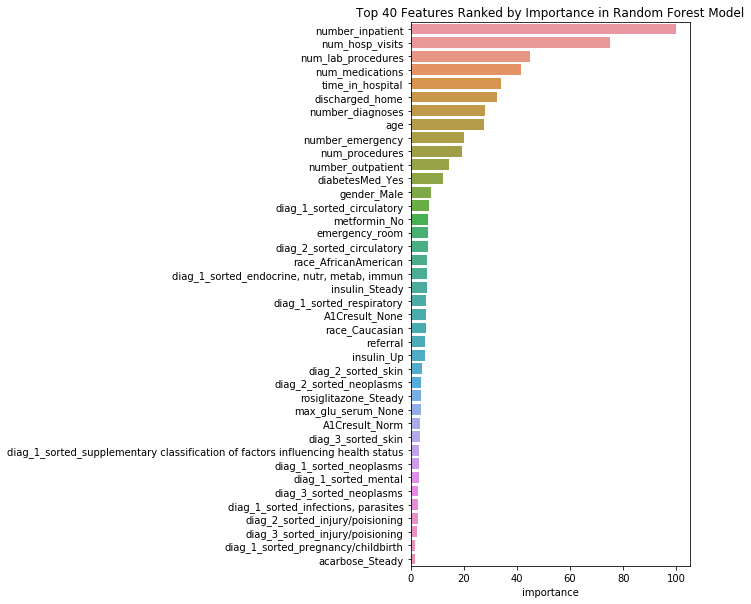

In [62]:
feature_importance = rfc_best.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())

feature_df= pd.DataFrame({'features': X.columns,
                          'importance':feature_importance})

feature_df.sort_values(by='importance', ascending=False, inplace=True)

feature_df.index = range(len(feature_df.features))

plt.figure(figsize=(5,10))

sns.barplot(y=feature_df.features[:40], x=feature_df.importance[:40])

plt.title('Top 40 Features Ranked by Importance in Random Forest Model')
plt.ylabel('')
plt.show()

Features can be broadly aggregated into the following groups:

    1. Number and type of hospital visits in the previous year
    2. Number of medical procedures and medications
    3. The length of time of the current medical visit
    4. The discharge status of the patient
    5. The age, race and gender of the patient
    6. Medical diagnoses and medications
    7. Diabetic testing results (A1C, insulin, blood glucose, etc.)
    
These findings suggest that medical providers should continue monitoring these features in their patients so that additional care can be provided when patients are identified as having a high probability of returning in the next 30 days. 